# Interpreting text models:  IMDB sentiment analysis

This notebook loads pretrained CNN model for sentiment analysis on IMDB dataset. It makes predictions on test samples and interprets those predictions using integrated gradients method.

The model was trained using an open source sentiment analysis tutorials described in: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb with the following changes:

- TEXT: set lower=True at initialization and call build_vocab() on the entire training data including validation to avoid mismatched indices
- model: save the entire model instead of just model.state_dict()

**Note:** Before running this tutorial, please install the spacy package, and its NLP modules for English language.

In [1]:
import captum

import spacy

import torch
import torchtext
import torchtext.data
import torch.nn as nn
import torch.nn.functional as F

from torchtext.vocab import Vocab

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

nlp = spacy.load('en')

In [2]:
for package in (captum, spacy, torch, torchtext):
    print(package.__name__, package.__version__)

captum 0.3.1
spacy 2.3.5
torch 1.7.1
torchtext 0.8.0a0+0f911ec


In [3]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

The dataset used for training this model can be found in: https://ai.stanford.edu/~amaas/data/sentiment/

Redefining the model in order to be able to load it.


In [4]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

Loads pretrained model and sets the model to eval mode.

The model can be downloaded here: https://github.com/pytorch/captum/blob/master/tutorials/models/imdb-model-cnn.pt

In [5]:
model = torch.load('models/imdb-model-cnn.pt')
model.eval()
model = model.to(device)

Forward function that supports sigmoid

In [6]:
def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))

Load a small subset of test data using torchtext from IMDB dataset.

In [7]:
TEXT = torchtext.data.Field(lower=True, tokenize='spacy')
Label = torchtext.data.LabelField(dtype = torch.float)

In [8]:
train, test = torchtext.datasets.IMDB.splits(text_field=TEXT,
                                      label_field=Label,
                                      train='train',
                                      test='test',
                                      path='data/aclImdb')
test, _ = test.split(split_ratio = 0.04)

Loading and setting up vocabulary for word embeddings using torchtext.

In [9]:
from torchtext import vocab

#loaded_vectors = vocab.GloVe(name='6B', dim=100)

# If you prefer to use pre-downloaded glove vectors, you can load them with the following two command line
loaded_vectors = torchtext.vocab.Vectors('data/glove.6B.100d.txt')
TEXT.build_vocab(train, vectors=loaded_vectors, max_size=len(loaded_vectors.stoi))
    
TEXT.vocab.set_vectors(stoi=loaded_vectors.stoi, vectors=loaded_vectors.vectors, dim=loaded_vectors.dim)
Label.build_vocab(train)

In [10]:
print('Vocabulary Size: ', len(TEXT.vocab))

Vocabulary Size:  101513


In order to apply Integrated Gradients and many other interpretability algorithms on sentences, we need to create a reference (aka baseline) for the sentences and its constituent parts, tokens.

Captum provides a helper class called `TokenReferenceBase` which allows us to generate a reference for each input text using the number of tokens in the text and a reference token index.

To use `TokenReferenceBase` we need to provide a `reference_token_idx`. Since padding is one of the most commonly used references for tokens, padding index is passed as reference token index.

In [11]:
PAD_IND = TEXT.vocab.stoi['pad']

In [12]:
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

Let's create an instance of `LayerIntegratedGradients` using forward function of our model and the embedding layer.
This instance of layer integrated gradients will be used to interpret movie rating review.

Layer Integrated Gradients will allow us to assign an attribution score to each word/token embedding tensor in the movie review text. We will ultimately sum the attribution scores across all embedding dimensions for each word/token in order to attain a word/token level attribution score.

Note that we can also use `IntegratedGradients` class instead, however in that case we need to precompute the embeddings and wrap Embedding layer with `InterpretableEmbeddingBase` module. This is necessary because we cannot perform input scaling and subtraction on the level of word/token indices and need access to the embedding layer.

In [13]:
lig = LayerIntegratedGradients(model, model.embedding)

In the cell below, we define a generic function that generates attributions for each movie rating and stores them in a list using `VisualizationDataRecord` class. This will ultimately be used for visualization purposes.

In [14]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    text = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=500, return_convergence_delta=True)

    print('pred: ', Label.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            Label.vocab.itos[pred_ind],
                            Label.vocab.itos[label],
                            Label.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

Below cells call `interpret_sentence` to interpret a couple handcrafted review phrases.

In [15]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.91 ) , delta:  tensor([0.0009], dtype=torch.float64)
pred:  neg ( 0.23 ) , delta:  tensor([8.5508e-05], dtype=torch.float64)
pred:  pos ( 0.89 ) , delta:  tensor([0.0002], dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([0.0008], dtype=torch.float64)
pred:  neg ( 0.45 ) , delta:  tensor([0.0003], dtype=torch.float64)
pred:  neg ( 0.06 ) , delta:  tensor([0.0001], dtype=torch.float64)


Below is an example of how we can visualize attributions for the text tokens. Feel free to visualize it differently if you choose to have a different visualization method.

In [16]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.91),pos,1.63,It was a fantastic performance ! pad
pos,neg (0.23),pos,0.30,Best film ever pad pad pad pad
pos,pos (0.89),pos,1.51,Such a great show ! pad pad
neg,neg (0.01),pos,-0.82,It was a horrible movie pad pad
neg,neg (0.45),pos,1.43,I 've never watched something as bad
neg,neg (0.06),pos,-0.46,It is a disgusting movie ! pad


Above cell generates an output similar to this:

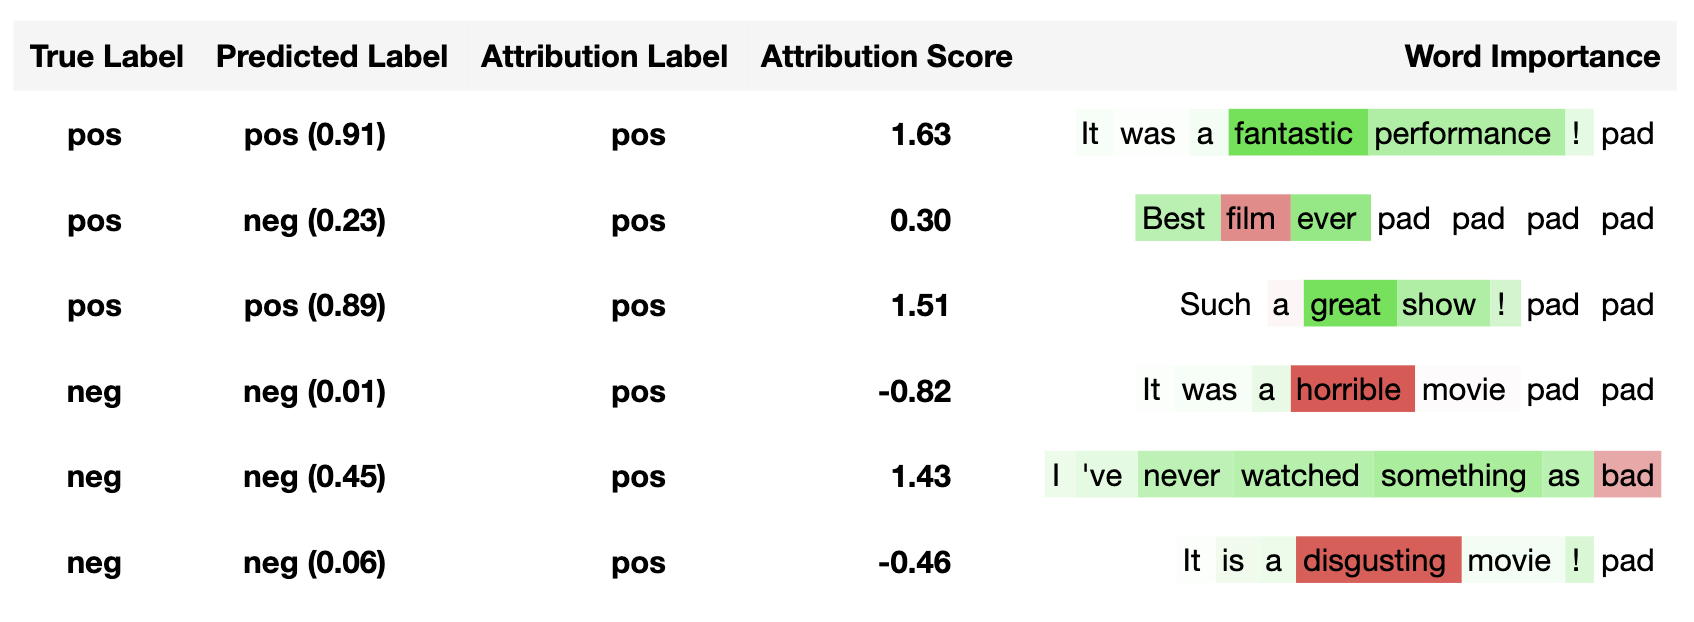

In [17]:
from IPython.display import Image
Image(filename='img/sentiment_analysis.png')